Importing Useful Stuff

In [1]:
import csv
import os
from functools import partial
import json

import geopandas as gpd
import matplotlib.pyplot as plt

from gerrychain import (
    Election,
    Graph,
    MarkovChain,
    Partition,
    accept,
    constraints,
    updaters,
)
from gerrychain.metrics import efficiency_gap, mean_median
from gerrychain.proposals import recom
from gerrychain.updaters import cut_edges
from gerrychain.tree import recursive_tree_part

Creating a path so I don't have to keep typing it, creating my dataframe and my graph (doing a graph this way is super slow so it's in its own cell so I don't have to rerun the cell very often)

In [2]:
path = "./CompleteCOwithDemographics.shp"
df = gpd.read_file(path)

In [3]:
graph = Graph.from_file(path)

Creating a file to save all the data from so stuff doesn't get cluttered.

In [4]:
newdir = "./SCOREPresentation/"
os.makedirs(os.path.dirname(newdir + "init.txt"), exist_ok=True)
with open(newdir + "init.txt", "w") as f:
    f.write("Created Folder")

Giving it information about the shapefile columns and elections and what not

In [5]:
unique_label = "VTDSD"
census_pop = "Sum_POP2_1"
pop_est = "Sum_block_"
congress = "CD116FP"
senate = "SLDUST"
house = "SLDLST"
county_col = "COUNTYFP"

num_elections = 5
election_names = [
    "AG18",
    "SEC18",
    "TRE18",
    "GOV18",
    "REG18",
]
election_columns = [
    ["AG_DEM18", "AG_REP18"],
    ["SEC_DEM18", "SEC_REP18"],
    ["TRE_DEM18", "TRE_REP18"],
    ["GOV_DEM18", "GOV_REP18"],
    ["REG_DEM18", "REG_REP18"],
]

num_districts = 7

In [6]:
############Why this isn't an updater I'm not entirely sure...
def num_splits(partition, level = county_col):
    df["current"] = df[unique_label].map(dict(partition.assignment))
    splits = sum(df.groupby(level)["current"].nunique() > 1)
    return splits

updaters = {
    "population": updaters.Tally(census_pop, alias="population"),
    "cut_edges": cut_edges,
}

elections = [
    Election(
        election_names[i],
        {"Democratic": election_columns[i][0], "Republican": election_columns[i][1]},
    )
    for i in range(num_elections)
]

election_updaters = {election.name: election for election in elections}

updaters.update(election_updaters)

In [7]:
enacted_partition = Partition(graph, congress, updaters)
ideal_population = sum(enacted_partition['population'].values()) / len(enacted_partition)

### This is how you create a random starting seed
#cddict = recursive_tree_part(graph, range(num_districts), ideal_population, census_pop, .001, 1)

#df['random'] = df.index.map(cddict)

#df.plot(column = 'random', cmap = 'jet')
#plt.savefig(newdir + 'random.png')
#plt.close()

#with open(newdir + 'random.json', 'w') as jf1:
#    json.dump(cddict, jf1)
    
#random_partition = Partition(graph, cddict, updaters)

AxesSubplot(0.125,0.170331;0.775x0.664339)


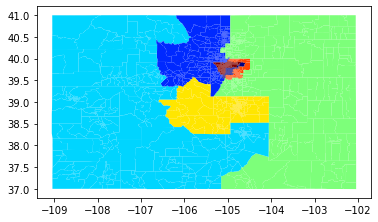

In [8]:
#print(df.plot(column = 'random', cmap = 'jet'))
print(df.plot(column = congress, cmap = 'jet'))

In [9]:
compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]), 2 * len(enacted_partition["cut_edges"])
)

In [10]:
proposal = partial(
    recom, pop_col=census_pop, pop_target=ideal_population, epsilon=0.02, node_repeats=2
)

In [13]:
initial_state = enacted_partition
plan_name = "2011 Enacted"

chain = MarkovChain(
    proposal=proposal,
    constraints=[
        constraints.within_percent_of_ideal_population(enacted_partition, 0.02),
        compactness_bound, constraints.contiguous # single_flip_contiguous#no_more_discontiguous
    ],
    accept=accept.always_accept,
    initial_state=initial_state,
    total_steps=10,
)

In [14]:
with open(newdir + "Start_Values.txt", "w") as f:
    f.write("Values for Starting Plan: Enacted Plan\n \n ")
    f.write("Initial Cut: " + str(len(initial_state["cut_edges"])))
    f.write("\n")
    f.write("\n")
    f.write("Initial County Splits: " + str(num_splits(initial_state)))
    f.write("\n")
    f.write("\n")

    for elect in range(num_elections):
        f.write(
            election_names[elect]
            + "District Percentages"
            + str(
                sorted(initial_state[election_names[elect]].percents("Democratic"))
            )
        )
        f.write("\n")
        f.write("\n")

        f.write(
            election_names[elect]
            + "Mean-Median :"
            + str(mean_median(initial_state[election_names[elect]]))
        )

        f.write("\n")
        f.write("\n")

        f.write(
            election_names[elect]
            + "Efficiency Gap :"
            + str(efficiency_gap(initial_state[election_names[elect]]))
        )

        f.write("\n")
        f.write("\n")

        f.write(
            election_names[elect]
            + "How Many Seats :"
            + str(initial_state[election_names[elect]].wins("Democratic"))
        )

        f.write("\n")
        f.write("\n")

In [15]:
pop_vec = []
cut_vec = []
votes = [[], [], [], [], [], [], [], [], [], [], [], [], [], []]
mms = []
egs = []
hmss = []

splits = []

t = 0
for part in chain:
    t+= 1
    print(t)
    splits.append(num_splits(part))

    pop_vec.append(sorted(list(part["population"].values())))
    cut_vec.append(len(part["cut_edges"]))
    mms.append([])
    egs.append([])
    hmss.append([])

    for elect in range(num_elections):
        votes[elect].append(sorted(part[election_names[elect]].percents("Democratic")))
        mms[-1].append(mean_median(part[election_names[elect]]))
        egs[-1].append(efficiency_gap(part[election_names[elect]]))
        hmss[-1].append(part[election_names[elect]].wins("Democratic"))

    print(t)
    with open(newdir + "mms" + str(t) + ".csv", "w") as tf1:
        writer = csv.writer(tf1, lineterminator="\n")
        writer.writerows(mms)

    with open(newdir + "egs" + str(t) + ".csv", "w") as tf1:
        writer = csv.writer(tf1, lineterminator="\n")
        writer.writerows(egs)

    with open(newdir + "hmss" + str(t) + ".csv", "w") as tf1:
        writer = csv.writer(tf1, lineterminator="\n")
        writer.writerows(hmss)

    with open(newdir + "pop" + str(t) + ".csv", "w") as tf1:
        writer = csv.writer(tf1, lineterminator="\n")
        writer.writerows(pop_vec)

    with open(newdir + "cuts" + str(t) + ".csv", "w") as tf1:
        writer = csv.writer(tf1, lineterminator="\n")
        writer.writerows([cut_vec])

    with open(newdir + "splits" + str(t) + ".csv", "w") as tf1:
        writer = csv.writer(tf1, lineterminator="\n")
        writer.writerows([splits])

    with open(newdir + "assignment" + str(t) + ".json", "w") as jf1:
        json.dump(dict(part.assignment), jf1)

    for elect in range(num_elections):
        with open(
            newdir + election_names[elect] + "_" + str(t) + ".csv", "w"
        ) as tf1:
            writer = csv.writer(tf1, lineterminator="\n")
            writer.writerows(votes[elect])

    df["plot" + str(t)] = df.index.map(dict(part.assignment))
    df.plot(column="plot" + str(t), cmap="jet")
    plt.savefig(newdir + "plot" + str(t) + ".png")
    plt.close()

    votes = [[], [], [], [], [], [], [], [], [], [], [], [], [], []]
    mms = []
    egs = []
    hmss = []
    pop_vec = []
    cut_vec = []
    splits = []

1
1
2
2
3
3
4
4
5
5
6
6
7
7
8
8
9
9
10
10


In [17]:
import numpy as np
import seaborn as sns


# sns.set_style('darkgrid')
sns.set_style("darkgrid", {"axes.facecolor": ".97"})